# Globular Cluster Member Identification: NGC 6397
NGC 6397 is the second closest globular cluster to Earth (second to M4).  Similar to our exploration of M4 using Gaia, we're going to make use of a catalog of confidently identified stellar members of the cluster to train classifiers capable of making such classifications from Gaia observations.

First we'll download the necessary data.  The catalog was originally pulled from [here](http://cdsarc.u-strasbg.fr/ftp/J/A+A/616/A12/), and can be found in `data/NGC6397-1.dat`.

From the Gaia archive we'll pull all objects in a 2 deg x 1.5 deg box centered on the cluster.  The query used is below, which was used to generate `data/gaia-NGC6397-neighborhood.csv`.

```sql
SELECT TOP 500000 gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.parallax,gaia_source.parallax_error,gaia_source.pm,gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,gaia_source.phot_g_mean_mag,gaia_source.phot_bp_mean_mag,gaia_source.phot_rp_mean_mag,gaia_source.bp_rp,gaia_source.radial_velocity,gaia_source.radial_velocity_error
FROM gaiadr3.gaia_source 
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	BOX('ICRS',265.17,-53.68,2,1.5)
)=1
```

# 1. Classification

1. Load the data and cross match the confident cluster members with the larger Gaia sample.

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [16]:
Cluster_df = pd.read_fwf('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/NGC6397-1.dat')
Cluster_df

,5921543639477589120,264.16385,-53.98070,19.941
0,5921539825546549120,264.25211,-54.06070,19.086
1,5921542265088057472,264.20510,-53.94871,18.252
2,5921539585011442304,264.33958,-54.03101,19.001
3,5921530887707179136,264.28545,-54.20321,17.558
4,5921543192800960640,264.19193,-54.01173,19.580
...,...,...,...,...
22110,5921705714351627520,265.42989,-53.58280,19.074
22111,5921744605276401152,265.16443,-53.75388,13.111
22112,5921694478712334080,265.40734,-53.92330,19.691
22113,5921744403412609792,265.24265,-53.75581,18.204


In [17]:
# Assignning names manually because they don't have it.
Cluster_df.columns = ['source_id', 'ra', 'dec', 'phot_g_mean_mag']

# Verify the column names
print(Cluster_df.head())

             source_id         ra       dec  phot_g_mean_mag
0  5921539825546549120  264.25211 -54.06070           19.086
1  5921542265088057472  264.20510 -53.94871           18.252
2  5921539585011442304  264.33958 -54.03101           19.001
3  5921530887707179136  264.28545 -54.20321           17.558
4  5921543192800960640  264.19193 -54.01173           19.580


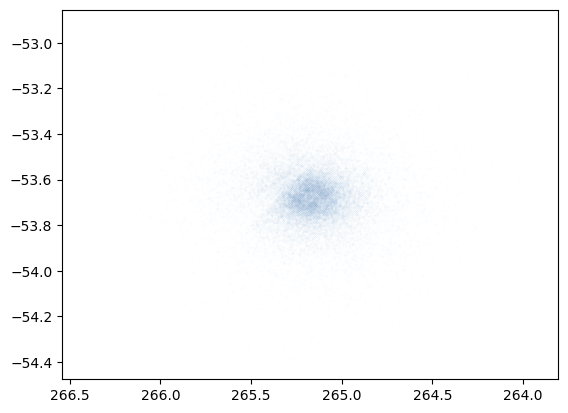

In [18]:
plt.scatter(Cluster_df.ra, Cluster_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [19]:
gaia_df = pd.read_csv('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/gaia-NGC6397-neighborhood.csv')
gaia_df

,source_id,ra,dec,parallax,parallax_error,pm,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error
0,5921580885428432512,264.170005,-53.499365,1.971942,1.147845,6.570742,-3.427931,1.380354,-5.605706,1.024108,20.746939,21.251717,20.174982,1.076734,NaN,NaN
1,5921543020999334144,264.170011,-54.034645,2.198161,1.562906,6.002902,-3.379062,1.845994,-4.961529,1.303942,20.789845,21.254570,19.668575,1.585995,NaN,NaN
2,5921569649783611008,264.170013,-53.799463,-0.357875,0.412176,5.155796,-3.728736,0.449804,-3.560725,0.369994,19.918226,20.593761,19.042880,1.550882,NaN,NaN
3,5921435028337797120,264.170019,-54.384088,1.181531,0.547741,13.745267,3.386150,0.530489,-13.321649,0.433790,20.157225,21.535680,18.972637,2.563044,NaN,NaN
4,5921966951438882816,264.170023,-53.163328,0.236054,0.413523,2.402006,-1.183284,0.382022,-2.090328,0.300960,19.705696,20.310032,19.047543,1.262489,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296551,5921716434605479424,266.169944,-53.608514,-0.867402,1.485600,9.257812,-1.645777,2.405371,-9.110352,1.666693,20.762312,21.288015,20.142715,1.145300,NaN,NaN
296552,5921718083862387456,266.169988,-53.554392,0.024822,0.731553,5.468407,-2.267840,0.808585,-4.975980,0.607609,20.413818,20.934456,19.738728,1.195728,NaN,NaN
296553,5921671079738396800,266.169995,-54.264224,4.664465,2.357308,13.306737,-5.366040,1.640666,-12.176816,1.550591,20.657871,NaN,NaN,NaN,NaN,NaN
296554,5921813019815200128,266.169997,-53.444160,1.875253,0.585601,9.939879,-3.430568,0.540236,-9.329116,0.426569,20.135847,20.743576,18.981106,1.762470,NaN,NaN


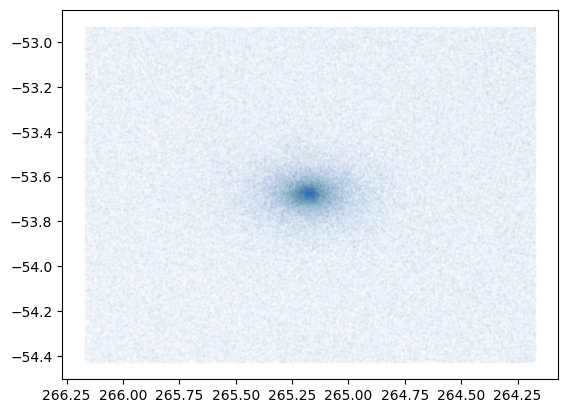

In [20]:
plt.scatter(gaia_df.ra, gaia_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [21]:
#cross-matching between the two data sets. 
# construct a selection array that selects for the cluster members identified in the cluster mini-catalog.

Cluster_sel = gaia_df['source_id'].isin(Cluster_df.source_id)
print(np.count_nonzero(Cluster_sel))

21772


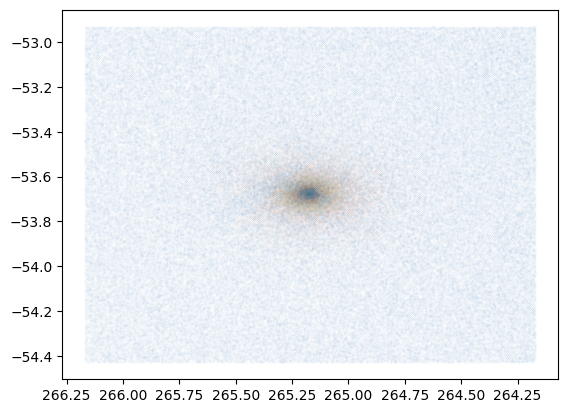

In [22]:
plt.scatter(gaia_df.ra[~Cluster_sel], gaia_df.dec[~Cluster_sel], s=0.0001)
plt.scatter(gaia_df.ra[Cluster_sel], gaia_df.dec[Cluster_sel], s=0.0001)
plt.gca().invert_xaxis()

2. Explore the data, sticking to position (e.g., ra, dec, etc.) and velocity (e.g. pm, etc.) measurements for now.  Are there particular observed quantities that seem useful for distinguishing cluster members from background stars?  Be sure to include lots of figures and discussion!

In [23]:
import seaborn as sns

3. Build and train a model (the type of model is up to you!) for classifying stars as members or non-members of NGC 6397 based on Gaia observations.  Be sure to show your process for building and improving the model.

In [24]:
gaia_df.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pm', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

4. How is your final model performing?  Could it have overfit the data?  Is it clear what the model learned?

5. Does your model find any new cluster member candidates?  If so, explore their properties.  Do they seem compelling?  Be sure to connect this discussion back to your response to 1.1.

# 2. Isochrones

Recall that stellar clusters are gravitationally bound groupings of stars born at the same time.  By looking at the H-R diagram of a cluster -- specifically where the population _leaves_ the main sequence -- we can determine the age of the cluster.  To do this we must know the typical main sequence lifetime of stars, which depends on their mass, metalicity, etc. and for that we must turn to stellar modeling.  [MESA](https://docs.mesastar.org) is a stellar modeling library which incorporates the physics important for stellar evolution into 1-D models of stars.  The results useful for our purposes are stellar evolution tracks, the expected trajectory of the star through the H-R diagram as it evolves in time.

[MIST](http://waps.cfa.harvard.edu/MIST/index.html) is an effort to supply a large database of MESA stellar track simulations for the purpose of producing isochrones.  If you imagine stacking up a cluster's worth of stellar evolution tracks, slicing through them at fixed age will produce an isochrone.

I've used the [MIST isochrone interpolator](http://waps.cfa.harvard.edu/MIST/interp_isos.html) to produce an isochrone based on known properties of NGC 6397 (metalicity, reddening due to dust, etc.), and saved `BP-RP`, `Gaia_G_EDR3=phot_g_mean_mag` (with distance modulus already applied), and phase (indicating stellar evolutionary phase) to a CSV file, `data/NGC6397_iso.csv`.

1. Read in and plot the isochrone in all its messy glory.  Try encoding stellar phase information (e.g., using color) if you can, to get a better grasp on the various stellar phases we're looking at (remember, more info on what this indicates can be found [here](http://waps.cfa.harvard.edu/MIST/README_tables.pdf)).

In [25]:
iso_data = pd.read_csv('C:/Users/rabin/sci-comp-ii-fall24/Working/final_NGC-6397-project/data/NGC6397_iso.csv')
iso_data

,Unnamed: 0,bp_rp,Gaia_G_EDR3,phase
0,0,2.239831,24.494631,0.0
1,1,2.217666,24.409392,0.0
2,2,2.194527,24.315058,0.0
3,3,2.172080,24.221950,0.0
4,4,2.150091,24.129340,0.0
...,...,...,...,...
1447,1447,-0.087272,22.475614,6.0
1448,1448,-0.080667,22.519457,6.0
1449,1449,-0.074041,22.562334,6.0
1450,1450,-0.067388,22.604324,6.0


2. Plot all of the Gaia data we pulled along with the isochrone.  In a new figure, plot the cluster members identified in `NGC6397-1.dat` with the isochrone.

3. Use the isochrone to argue whether any new cluster candidates your classifier found are viable.

4. Now include color and brightness information in your model and retrain your classifier.  Does it perform any better?  Did you expect the outcome?

# 510 Students

1. Use a completely different technique to classify cluster members.  How do your results compare to previous attempts?

2. Do you think your models have learned anything useful for identifying members of other clusters?  Why or why not?

3. Can you think of ways we could use the isochrone explicitly to improve our model?